In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot 
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
import datetime
import sys
import seaborn as sns
import statsmodels
import statsmodels.stats.diagnostic as diag
from statsmodels.tsa.stattools import adfuller
from scipy.stats.mstats import normaltest
from matplotlib.pyplot import acorr
plt.style.use('fivethirtyeight')
%matplotlib inline

In [3]:
df = pd.read_csv('/content/drive/MyDrive/data_stocks.csv')

In [4]:
df.head()

,DATE,SP500,NASDAQ.AAL,NASDAQ.AAPL,NASDAQ.ADBE,NASDAQ.ADI,NASDAQ.ADP,NASDAQ.ADSK,NASDAQ.AKAM,NASDAQ.ALXN,NASDAQ.AMAT,NASDAQ.AMD,NASDAQ.AMGN,NASDAQ.AMZN,NASDAQ.ATVI,NASDAQ.AVGO,NASDAQ.BBBY,NASDAQ.BIIB,NASDAQ.CA,NASDAQ.CBOE,NASDAQ.CELG,NASDAQ.CERN,NASDAQ.CHRW,NASDAQ.CHTR,NASDAQ.CINF,NASDAQ.CMCSA,NASDAQ.CME,NASDAQ.COST,NASDAQ.CSCO,NASDAQ.CSX,NASDAQ.CTAS,NASDAQ.CTSH,NASDAQ.CTXS,NASDAQ.DISCA,NASDAQ.DISCK,NASDAQ.DISH,NASDAQ.DLTR,NASDAQ.EA,NASDAQ.EBAY,NASDAQ.EQIX,...,NYSE.UA,NYSE.UAA,NYSE.UAL,NYSE.UDR,NYSE.UHS,NYSE.UNH,NYSE.UNM,NYSE.UNP,NYSE.UPS,NYSE.URI,NYSE.USB,NYSE.UTX,NYSE.V,NYSE.VAR,NYSE.VFC,NYSE.VLO,NYSE.VMC,NYSE.VNO,NYSE.VTR,NYSE.VZ,NYSE.WAT,NYSE.WEC,NYSE.WFC,NYSE.WHR,NYSE.WM,NYSE.WMB,NYSE.WMT,NYSE.WRK,NYSE.WU,NYSE.WY,NYSE.WYN,NYSE.XEC,NYSE.XEL,NYSE.XL,NYSE.XOM,NYSE.XRX,NYSE.XYL,NYSE.YUM,NYSE.ZBH,NYSE.ZTS
0,1491226200,2363.6101,42.3300,143.6800,129.6300,82.040,102.2300,85.2200,59.760,121.52,38.99,14.61,164.630,888.5500,49.850,219.11,39.43,274.080,31.780,81.03,124.89,58.820,77.725,330.73,72.430,37.470,119.385,167.740,33.7400,46.6450,126.8600,59.720,83.5400,29.020,28.370,63.4900,78.4600,89.90,33.3975,400.9400,...,18.6100,19.8901,70.69,36.26,124.66,164.62,47.0400,106.27,107.65,124.5901,51.6200,112.36,89.35,91.130,55.21,66.5900,120.1300,100.35,65.07,48.730,156.390,60.46,55.70,171.83,73.08,29.62,72.1000,52.160,20.34,34.00,84.370,119.035,44.40,39.88,82.03,7.36,50.22,63.86,122.000,53.350
1,1491226260,2364.1001,42.3600,143.7000,130.3200,82.080,102.1400,85.6500,59.840,121.48,39.01,14.71,164.680,887.1173,49.940,219.98,39.68,273.990,31.780,81.21,124.99,58.495,77.940,330.73,72.040,37.540,118.810,167.776,33.8800,46.6100,126.8600,59.830,83.9400,29.140,28.400,63.4600,78.6200,89.73,33.3950,400.4000,...,18.5100,19.8901,70.77,36.26,124.82,164.39,47.0400,106.27,107.65,124.5901,51.5800,112.36,89.35,91.210,55.12,66.3550,120.1300,100.03,65.04,48.752,157.190,59.93,55.81,171.54,72.95,29.64,72.1800,52.245,20.32,34.07,84.370,119.035,44.11,39.88,82.03,7.38,50.22,63.74,121.770,53.350
2,1491226320,2362.6799,42.3100,143.6901,130.2250,82.030,102.2125,85.5100,59.795,121.93,38.91,14.64,164.905,887.5110,49.860,219.39,39.60,274.275,31.765,81.21,125.00,58.470,77.815,330.73,72.055,37.610,118.830,168.000,33.9000,46.8850,126.9576,59.905,83.9400,29.150,28.375,63.5250,78.6311,89.24,33.4100,401.9850,...,18.4397,19.7900,70.62,36.19,124.82,165.30,46.9800,106.38,107.31,124.7100,51.4600,112.13,89.16,91.080,55.09,66.2417,120.3368,100.39,65.08,48.720,157.070,60.08,55.64,171.55,72.98,29.67,72.3192,52.200,20.26,34.11,84.585,119.260,44.09,39.98,82.02,7.36,50.12,63.75,121.700,53.365
3,1491226380,2364.3101,42.3700,143.6400,130.0729,82.000,102.1400,85.4872,59.620,121.44,38.84,14.63,164.760,886.2700,49.915,219.30,39.57,273.590,31.830,81.13,124.73,58.420,77.950,330.73,72.140,37.620,118.680,168.200,33.8499,46.7000,126.7000,59.700,83.7064,29.125,28.350,63.5300,78.7060,89.17,33.3350,401.5000,...,18.3700,19.7875,70.62,36.00,124.82,165.16,46.8097,106.33,107.49,124.4889,51.3800,112.01,89.06,91.015,55.21,66.1700,120.3100,100.39,64.95,48.695,156.945,60.39,55.64,171.26,73.09,29.79,72.4300,52.140,20.20,33.97,84.460,119.260,44.25,39.99,82.02,7.35,50.16,63.88,121.700,53.380
4,1491226440,2364.8501,42.5378,143.6600,129.8800,82.035,102.0600,85.7001,59.620,121.60,38.93,14.67,164.850,886.5800,49.915,219.18,39.55,273.540,31.830,81.12,124.83,58.600,78.050,330.73,72.215,37.625,118.935,168.040,33.8400,46.8562,126.8900,59.500,84.0000,29.140,28.410,63.6344,78.5850,88.95,33.4000,399.7704,...,18.3850,19.7324,70.78,36.01,124.82,165.24,47.0200,106.56,107.48,125.2449,51.4347,112.23,89.10,91.000,55.32,66.1800,120.3600,100.11,64.84,48.630,157.160,60.18,55.68,171.18,72.99,29.71,72.4800,52.140,20.22,34.00,84.470,119.610,44.11,39.96,82.03,7.36,50.20,63.91,121.695,53.240


In [6]:
features = ['NASDAQ.AAPL','NASDAQ.ADP','NASDAQ.CBOE','NASDAQ.CSCO','NASDAQ.EBAY']
col = ['DATE'] + features
df1 = df[col]
df1.head()

,DATE,NASDAQ.AAPL,NASDAQ.ADP,NASDAQ.CBOE,NASDAQ.CSCO,NASDAQ.EBAY
0,1491226200,143.6800,102.2300,81.03,33.7400,33.3975
1,1491226260,143.7000,102.1400,81.21,33.8800,33.3950
2,1491226320,143.6901,102.2125,81.21,33.9000,33.4100
3,1491226380,143.6400,102.1400,81.13,33.8499,33.3350
4,1491226440,143.6600,102.0600,81.12,33.8400,33.4000


In [7]:
df1.isnull().sum()

DATE           0
NASDAQ.AAPL    0
NASDAQ.ADP     0
NASDAQ.CBOE    0
NASDAQ.CSCO    0
NASDAQ.EBAY    0
dtype: int64

In [9]:
df1['DATE'] = pd.to_datetime(df['DATE'], unit='s')
df1.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,DATE,NASDAQ.AAPL,NASDAQ.ADP,NASDAQ.CBOE,NASDAQ.CSCO,NASDAQ.EBAY
0,2017-04-03 13:30:00,143.6800,102.2300,81.03,33.7400,33.3975
1,2017-04-03 13:31:00,143.7000,102.1400,81.21,33.8800,33.3950
2,2017-04-03 13:32:00,143.6901,102.2125,81.21,33.9000,33.4100
3,2017-04-03 13:33:00,143.6400,102.1400,81.13,33.8499,33.3350
4,2017-04-03 13:34:00,143.6600,102.0600,81.12,33.8400,33.4000


In [10]:
df1['Month'] = df1['DATE'].dt.date 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
col = ['Month'] + features
df2 = df1[col]
df2.head()

,Month,NASDAQ.AAPL,NASDAQ.ADP,NASDAQ.CBOE,NASDAQ.CSCO,NASDAQ.EBAY
0,2017-04-03,143.6800,102.2300,81.03,33.7400,33.3975
1,2017-04-03,143.7000,102.1400,81.21,33.8800,33.3950
2,2017-04-03,143.6901,102.2125,81.21,33.9000,33.4100
3,2017-04-03,143.6400,102.1400,81.13,33.8499,33.3350
4,2017-04-03,143.6600,102.0600,81.12,33.8400,33.4000


In [16]:
data = df2.copy()
data['Month'] = pd.to_datetime(data['Month'])

In [17]:
# forecasting for NASDAQ.AAPL
AAPL = data[['Month', features[0]]]

In [18]:
AAPL.set_index('Month', inplace=True)
AAPL.head()

,NASDAQ.AAPL
Month,
2017-04-03,143.6800
2017-04-03,143.7000
2017-04-03,143.6901
2017-04-03,143.6400
2017-04-03,143.6600


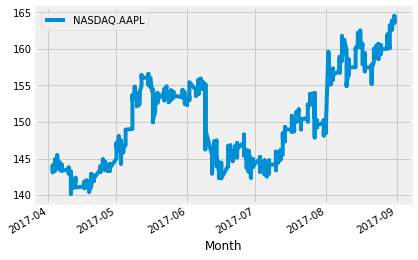

In [19]:
AAPL.plot()

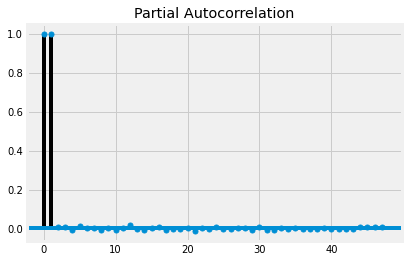

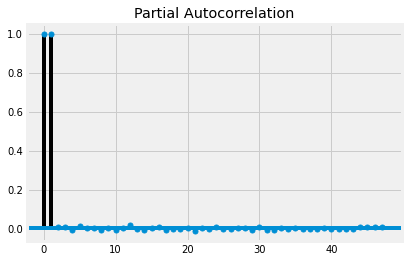

In [24]:
# Stationary means mean,variance and covariance is constant over periods.

plot_pacf(AAPL)

In [25]:
# convert series to stationary
AAPL.shift(1)

,NASDAQ.AAPL
Month,
2017-04-03,NaN
2017-04-03,143.6800
2017-04-03,143.7000
2017-04-03,143.6901
2017-04-03,143.6400
...,...
2017-08-31,164.1400
2017-08-31,164.1100
2017-08-31,164.1200


In [26]:
X = AAPL.values
train = X[0:28886] # 27 data as train data
test = X[28886:] # 9 data as test data
print(train.size)
print(test.size)
predictions = []

28886
12380


### ARIMA model

In [27]:
import itertools
p=d=q=range(0,6)
pdq=list(itertools.product(p,d,q))

In [28]:
import warnings
warnings.filterwarnings('ignore')
for param in pdq:
    try:
        model_arima = ARIMA(train, order=param)
        model_arima_fit = model_arima.fit()
        print(param,model_arima_fit.aic)
    except:
        continue

(0, 0, 0) 170326.9720446082
(0, 0, 1) 131018.03599865251
(0, 0, 2) 95780.67244459385
(0, 1, 0) -64708.712006361384
(0, 1, 1) -64706.8773153409
(0, 1, 2) -64718.286096672164
(0, 1, 3) -64719.67999909348
(0, 1, 4) -64724.746502434966
(0, 1, 5) -64723.27395737222
(0, 2, 0) -44617.132207470175
(0, 2, 1) -64678.284486396515
(1, 0, 0) -64703.106010175194
(1, 0, 1) -64701.25996864913
(1, 0, 2) -64712.5673838841
(1, 0, 3) -64714.01381575866
(1, 0, 4) -64719.007413574145
(1, 0, 5) -64717.516473395575
(1, 1, 0) -64706.87029558887
(1, 1, 1) -64714.63157446154
(1, 1, 2) -64725.38695947903
(1, 2, 0) -52566.60024359125
(1, 2, 1) -64686.65886623964
(1, 2, 2) -64694.13072215939
(1, 2, 3) -64689.77042366289
(1, 2, 4) -64699.29773593451
(1, 2, 5) -64699.32708949155
(2, 0, 0) -64701.25345516886
(2, 0, 1) -64709.05736467696
(2, 0, 2) -64719.706396922964
(2, 0, 3) -64717.71698047986
(2, 0, 4) -64716.79946405871
(2, 0, 5) -64715.50400907954
(2, 1, 0) -64717.93086809853
(2, 1, 1) -64725.403060836645
(2, 2, 0

In [30]:
#p,d,q 
#p -> Periods taken for auto regressive model
#d -> Integrated order, difference
#q -> Periods in moving average model
model_arima = ARIMA(train, order=(3,1,3))
model_arima_fit = model_arima.fit()
print(model_arima_fit.aic)

-64730.23106387876


In [31]:
predictions = model_arima_fit.forecast(steps=12380)[0]
predictions

array([150.61065422, 150.61166805, 150.6121023 , ..., 153.58211214,
       153.58235211, 153.58259208])

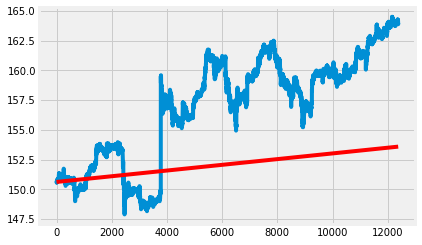

In [32]:
plt.plot(test)
plt.plot(predictions, color='red')

In [34]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test,predictions)

37.57177959799861

### I've done forecasting only for NASDAQ.AAPL because of the long train time on my slow cpu. But it's similar for other stocks.